# 数据分析

本节主要介绍空间数据分析的方法，分为非空间数据分析和空间数据分析两部分。

In [1]:
londonhp <- rgdal::readOGR("data/LNHP03.shp")

Warning message in OGRSpatialRef(dsn, layer, morphFromESRI = morphFromESRI, dumpSRS = dumpSRS, :
“Discarded datum OSGB_1936 in CRS definition: +proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +units=m +no_defs”


OGR data source with driver: ESRI Shapefile 
Source: "/home/hpdell/RTraining/data/LNHP03.shp", layer: "LNHP03"
with 2108 features
It has 17 fields


数据集 `londonborough` 数据包含了该地区的行政边界，使用之前需要先矫正一下坐标系。

In [2]:
library(sp)
data(LondonBorough, package = "GWmodel")
proj4string(londonborough) <- proj4string(londonhp)

Warning message in proj4string(londonhp):
“CRS object has comment, which is lost in output”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in CRS definition”


In [3]:
library(tmap)

## 相关分析

相关分析是分析变量之间的相关性，从而为回归分析的变量选择提供依据。
进行相关分析的包有很多，这里主要介绍 `PerformanceAnalytics` 的 `chart.Correlation()` 函数。该函数的特点是提供的信息比较多，有散点图、直方图、相关系数值等，而且相关系数值的字体大小会随着相关系数的大小而变化。

In [ ]:
PerformanceAnalytics::chart.Correlation(londonhp@data[, c("PURCHASE", "BATH2", "FLOORSZ", "PROF", "UNEMPLOY")], histogram = T)

由此我们可以看到，`PURCHASE` 变量和 `BATH2` `FLOORSZ` `PROF` 三个变量相关性比较强。

该函数默认使用皮尔逊相关系数，如果像计算斯皮尔曼相关系数，则使用 `method` 参数进行指定。

In [ ]:
PerformanceAnalytics::chart.Correlation(londonhp@data[, c("PURCHASE", "BATH2", "FLOORSZ", "PROF", "UNEMPLOY")], histogram = T, method = "spearman")

## 空间相关分析

空间相关分析，主要根据全局莫兰指数和局部莫兰指数进行分析。主要用到的函数包为 `spdep` 包。

In [ ]:
library(spdep)

### 全局空间自相关

莫兰指数的定义如下：$$ I = \frac{n}{\sum_i \sum_j w_{ij}} \frac{ \sum_i \sum_j w_{ij} (z_i - \bar{z})(z_j - \bar{z}) }{ \sum_i (z_i - \bar{z})^2 } $$
其中 $w$ 为根据空间邻域计算的权重矩阵。

在 R 中，该值的计算方法是

In [ ]:
londonhp.nb <- knn2nb(knearneigh(londonhp, k = 4, longlat = F))
londonhp.nb.s <- make.sym.nb(londonhp.nb)
moran.test(londonhp$PURCHASE, listw = nb2listw(londonhp.nb.s))

> 中间涉及到 `knn2nb` `knearneigh` `make.sym.nb` `nb2listw` 几个函数，都是用来生成空间邻域权重矩阵的，具体含义和使用方法请查看帮助文档。

在结果中可以看到，莫兰指数 $I$ 的 $p$ 值很小，表示数据中含有自相关性；否则即使 $I$ 不是 0，也不能认为有相关性。
然后根据莫兰指数 $I$ 的值，判断相关性的类型：

- $I > 0$ 表示正相关
- $I < 0$ 表示负相关

除了莫兰指数以外，还有 Geary 系数也比较常用，该系数的用法请参考《R 语言空间统计与分析实践教程》。

### 局部空间自相关

局部空间自相关使用局部莫兰指数，其定义如下 $$ I_i = \frac{n}{\sum_j w_{ij}} \frac{ \sum_j w_{ij} (z_i - \bar{z})(z_j - \bar{z}) }{ \sum_k (z_k - \bar{z})^2 } $$
其中 $w$ 为根据空间邻域计算的权重矩阵。

在 R 中使用 `localmoran()` 函数进行计算，

In [ ]:
londonhp.localmoran.PURCHASE <- localmoran(londonhp$PURCHASE, listw = nb2listw(londonhp.nb.s, style = "W"))
head(londonhp.localmoran.PURCHASE)

下面我们可以将其在地图上进行可视化，来观察变量的局部相关性分布情况。

In [ ]:
londonhp.localmoran.PURCHASE.sdf <- data.frame(londonhp@coords, londonhp.localmoran.PURCHASE)
coordinates(londonhp.localmoran.PURCHASE.sdf) <- ~ coords.x1 + coords.x2
proj4string(londonhp.localmoran.PURCHASE.sdf) <- proj4string(londonhp)
tm_shape(londonborough) + tm_polygons(col = "white") + tm_shape(londonhp.localmoran.PURCHASE.sdf) + tm_symbols(col = "Ii", size = 0.2)

函数 `moran.plot` 用于辅助查看空间自相关特征，使用方法如下

In [ ]:
moran.plot(londonhp$PURCHASE, nb2listw(londonhp.nb.s, style = "W"), pch = 19)

根据点集落入的象限，可以分析空间自相关特征。

## 地理加权分析

地理加权分析，其方法主要由 `GWmodel` 包提供，包括地理加权汇总统计分析（GWSS）、地理加权回归分析（GWR）、地理加权主成分分析（GWPCA）、地理加权判别分析（GWDA）等。
不同地分析方法分别有不同的作用，需要搭配使用。

In [4]:
library(GWmodel)

Loading required package: maptools

Checking rgeos availability: TRUE

Loading required package: robustbase

Loading required package: Rcpp

Loading required package: spatialreg

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Loading required package: Matrix

Registered S3 methods overwritten by 'spatialreg':
  method                   from 
  residuals.stsls          spdep
  deviance.stsls           spdep
  coef.stsls               spdep
  print.stsls              spdep
  summary.stsls            spdep
  print.summary.stsls      spdep
  residuals.gmsar          spdep
  deviance.gmsar           spdep
  coef.gmsar               spdep
  fitted.gmsar             spdep
  print.gmsar              spdep
  summary.gmsar            spdep
  print.summary.gmsar      spdep
  print.lagmess            spdep
  summary.lagmess          spdep
  

### GWR

地理加权回归分析是考虑空间异质性的回归方法，其回归方程是 $$ y_i = \beta_{i0} + \sum_{k=1}^{K}\beta_{ik}x_{ik} + \epsilon_i $$
其中 $ y_i $ 是在位置 $i$ 处的因变量； $ x_{ik} $ 是位置 $i$ 上第 $k$ 个自变量; $ K $ 自变量总数；$ \beta_{i0} $ 是位置 $i$ 上的截距；$\beta_{ik}$ 位置 $i$ 上第 $k$ 个自变量的回归系数；$ \epsilon_i $ 是位置 $i$ 上的随机误差，服从正态分布。 

其解算方法是加权最小二乘，即 $$ \hat{\beta}_i = \left( X^T W_i X \right)^{-1} \left( X^T W_i y \right) $$
其中 $w_{ij}$ 通过核函数和回归点 $i,j$ 之间的距离计算。距离一般是欧氏距离，或者路网距离、通勤时间等。核函数主要有以下几种：

- gaussian 非截断型带宽  $$w_{ij} = \exp\left[-\frac{1}{2}\left( \frac{d_{ij}}{b} \right)^2 \right]$$
- bisquare 截断型带宽:  $$w_{ij} = \left\{ \begin{array}{ll} \left(1 - \frac{d_{ij}^2}{b^2} \right)^2, & \mathrm{if} d_{ij} \leq b \\ 0, & \mathrm{otherwise} \end{array}  \right.$$
- triqurbe 截断型带宽: $$w_{ij} = \left\{ \begin{array}{ll} \left(1 - \frac{d_{ij}^2}{b^3} \right)^3, & \mathrm{if} d_{ij} \leq b \\ 0, & \mathrm{otherwise} \end{array}  \right.$$

进行 GWR 分析的方法主要有三步：模型优选、带宽优选、模型拟合。前两步主要是用于选择一个最优参数，其结果是参考性的。

#### 模型优选

使用 `gwr.model.selection()` 函数进行模型优选，该函数需要指定因变量和自变量。

In [ ]:
londonhp.indep.vars <- colnames(londonhp@data)[-1]
londonhp.depen.vars <- colnames(londonhp@data)[1]
londonhp.model.sel <- gwr.model.selection(DeVar = londonhp.depen.vars, InDeVars = londonhp.indep.vars, data = londonhp, 
                                          bw = Inf, adaptive = T, kernel = "gaussian", longlat = F,
                                          parallel.method = "omp", parallel.arg = 8)
londonhp.model.sort <- gwr.model.sort(londonhp.model.sel, length(londonhp.indep.vars), londonhp.model.sel[[2]][,2])

然后根据下面三张图，可以分析究竟应该选择哪个模型

In [ ]:
## 模型列表
gwr.model.view(DeVar = londonhp.depen.vars, InDeVars = londonhp.indep.vars, londonhp.model.sort[[1]])
## 模型 AIC 值
londonhp.model.ruler <- londonhp.model.sort[[2]][,2]
plot(londonhp.model.ruler, type = "b", pch = 20, lty = 2)
## 模型 AIC 变化
londonhp.model.ruler.diff <- c(0, diff(londonhp.model.ruler))
plot(londonhp.model.ruler.diff, ylim = c(-50, 0))
abline(h = -3)
text(x = 1:length(londonhp.model.ruler.diff), y = londonhp.model.ruler.diff, labels = as.character(1:length(londonhp.model.ruler.diff)))

可以看到，第 115 个模型是比较好的模型。下面有两种方法获取该模型，一种是根据第一张图查找 115 号模型的自变量。
另一种方法是，直接根据输出结果获取表达式。

In [ ]:
londonhp.model.best <- londonhp.model.sort[[1]][[115]]
londonhp.model.formula <- formula(londonhp.model.best[[1]])
londonhp.model.indep <- londonhp.model.best[[2]]
londonhp.model.formula

#### 带宽优选

在选好了模型的基础上，使用 `bw.gwr()` 函数进行带宽优选。

In [ ]:
londonhp.bw <- bw.gwr(londonhp.model.formula, londonhp,
                      kernel = "gaussian", adaptive = T, longlat = F,
                      parallel.method = "omp", parallel.arg = 8)

返回的 `londonhp.bw` 即是最优带宽值。

#### 模型解算

在选好模型和带宽的基础上，使用 `gwr.basic()` 函数解算模型。

In [ ]:
londonhp.model.gwr <- gwr.basic(londonhp.model.formula, londonhp,
                                bw = londonhp.bw, kernel = "gaussian", adaptive = T, longlat = F,
                                parallel.method = "omp", parallel.arg = 8)
londonhp.model.gwr

返回结果 `londonhp.model.gwr` 是一个列表，最重要的是以下两个键值对：

- `SDF` 是一个 Spatial\*DatFrame, 和原始数据的类型一致，包含每个点上的回归系数和截距，以及一些其他信息。
- `diagnostic` 诊断信息，包含 AIC, $R^2$ 值等，在上述结果输出中也可以看到。

我们可以先将 `SDF` 的值的列名进行输出

In [ ]:
colnames(londonhp.model.gwr$SDF@data)

可见，该变量包含以下列：

- 前 $k$ 列（$k$ 是自变量数+1）是每个要素的回归系数
- 后面跟着真值 $y$，估计值 $\hat{y}$，残差值 $\epsilon$， CV 值和学生残差值
- 后面跟着 $k$ 个回归系数（包括截距）的标准差
- 后面跟着 $k$ 个回归系数（包括截距）的 t 检验值
- 最后一列是局部 $R^2$ 值

我们可以对这些系数进行可视化输出

In [ ]:
tm_shape(londonhp.model.gwr$SDF) + tm_symbols(col = "Intercept", size = 0.2)

下面我们使用数据集 `LondonBorough` 制作完整的专题图。

In [ ]:
tm_shape(londonborough) + tm_polygons(col = "white") + tm_shape(londonhp.model.gwr$SDF) + tm_symbols(col = "Intercept", size = 0.2)

### GWSS

GWSS 包含以下几类地理加权汇总统计量：

- 局部平均数 $$ \bar{x}(u_i,v_i) = \frac{\sum_j x_j w_{ij}}{\sum_j w_{ij}} $$
- 局部标准差  $$ SD(u_i,v_i) = \frac{\sqrt{\sum_j (x_j - \bar{x}(u,v))^2 w_{ij}}}{\sum_j w_{ij}} $$
- 局部方差   $$ Var(u_i,v_i) = \frac{{\sum_j (x_j - \bar{x}(u,v))^2 w_{ij}}}{\sum_j w_{ij}} $$
- 局部偏度
- 局部变异系数
- 局部协方差 $$ Cov_{x,y}(u_i,v_i) = \frac{{\sum_j  w_{ij} (x_j - \bar{x}_i(u_i,v_i)) (y_j - \bar{y}_i)(u_i,v_i)}}{\sum_j w_{ij}} $$
- 局部皮尔逊相关系数 $$ Corr_{x,y}(u_i,v_i) = \frac{ Cov_{x,y}(u_i,v_i) }{ SD_x(u_i,v_i) \times SD_y(u_i,v_i) } $$
- 局部斯皮尔曼相关系数

函数 `gwss()` 提供该功能。GWSS 的使用没有像 GWR 那么复杂，只是计算几个统计量。使用方法如下

In [ ]:
londonhp.gwss <- gwss(londonhp, vars = c("PURCHASE", "FLOORSZ", "PROF", "UNEMPLOY"), 
                      kernel = "gaussian", adaptive = TRUE, bw = 100, longlat = F)
londonhp.gwss

同样，变量 `londonhp.gwss` 是一个列表，其中有一个 `SDF` 的键值对，包含了每个要素上 GWSS 统计量的计算结果。

In [ ]:
colnames(londonhp.gwss$SDF@data)

我们也可以将其进行可视化

In [ ]:
tm_shape(londonborough) + tm_polygons(col = "white") + tm_shape(londonhp.gwss$SDF) + tm_symbols(col = "PURCHASE_LM", size = 0.2)
tm_shape(londonborough) + tm_polygons(col = "white") + tm_shape(londonhp.gwss$SDF) + tm_symbols(col = "Corr_PURCHASE.PROF", size = 0.2)

### GWPCA

GWPCA 是一种局部加权的 PCA 算法，用于分析局部尺度下主成分的不同。

在进行主成分分析之前，我们需要对数据进行归一化处理，处理的方法是
$$ \tilde{x}_i = \frac{x_i - \bar{x}}{\mathrm{Var}(x)} $$
在 R 中，使用 `scale` 函数即可

In [5]:
londonhp.scaled <- londonhp
londonhp.scaled@data <- as.data.frame(scale(as.matrix(londonhp@data[,c("FLOORSZ", "PROF", "UNEMPLOY")])))

使用 `gwpca()` 函数进行 GWPCA 解算。

In [6]:
londonhp.gwpca <- gwpca(londonhp.scaled, vars = c("FLOORSZ", "PROF", "UNEMPLOY"), k = 2,
                        kernel = "gaussian", adaptive = TRUE, bw = 100, longlat = F)
londonhp.gwpca

Warning message in proj4string(data):
“CRS object has comment, which is lost in output”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in CRS definition”


   ***********************************************************************
   *                       Package   GWmodel                             *
   ***********************************************************************
   Program starts at: 2021-01-14 10:58:44 
   Call:
   
   Variables concerned:  FLOORSZ PROF UNEMPLOY
   The number of retained components:  2
   Number of data points: 2108
   ***********************************************************************
   *                Results of Principal Components Analysis               *
   ***********************************************************************
Importance of components:
                          Comp.1    Comp.2    Comp.3
Standard deviation     1.2425881 0.9934353 0.6848803
Proportion of Variance 0.5146751 0.3289713 0.1563537
Cumulative Proportion  0.5146751 0.8436463 1.0000000

Loadings:
         Comp.1 Comp.2 Comp.3
FLOORSZ   0.184  0.977  0.105
PROF      0.688 -0.205  0.696
UNEMPLOY -0.702  0.055  0.710

   

返回值 `londonhp.gwpca` 也是一个列表，主要有以下几个键值对：

- `SDF` : 存储各个要素上的 GWPCA 分析的结果，包含前 k 个主成分的值 `Comp.1_PV` `Comp.2_PV` ... `Comp.$k$_PV`，累积占比 `local_CP`，以及优胜变量 `win_var_PC1` 。
- `loadings` : 各个要素上的载荷矩阵
- `gwpca.scores` : 各个要素上的得分值（只有设置了 `score` 参数才有值）
- `local.PV` : 各个要素上的特征值

我们可以将优胜变量进行可视化

Warning message in sp::proj4string(obj):
“CRS object has comment, which is lost in output”


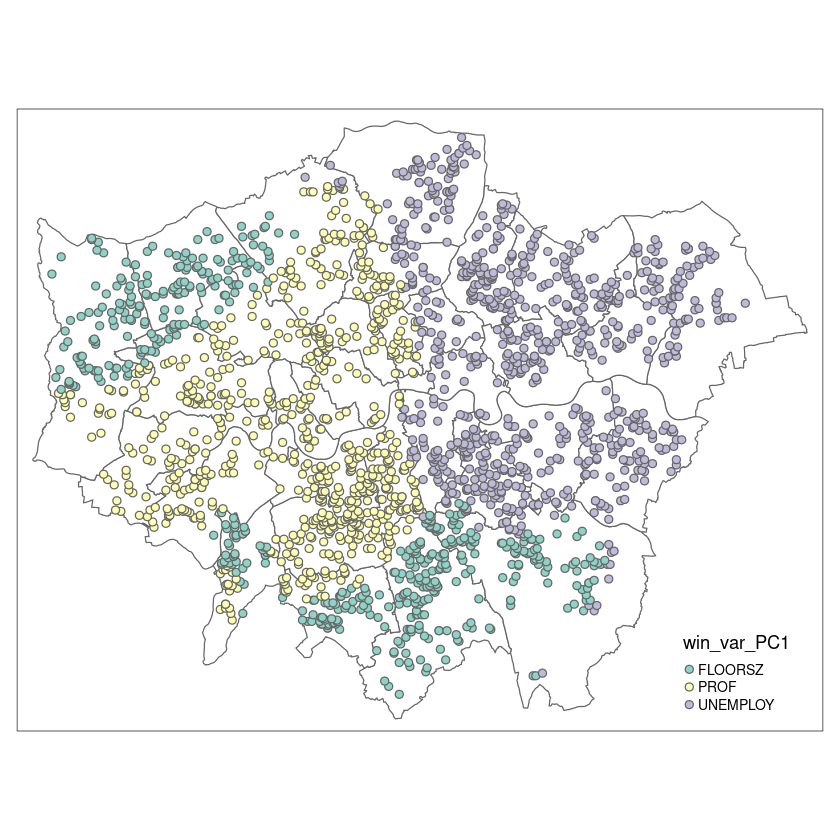

In [7]:
tm_shape(londonborough) + tm_polygons(col = "white") + tm_shape(londonhp.gwpca$SDF) + tm_symbols(col = "win_var_PC1", size = 0.2)

也可以对载荷矩阵进行可视化，以分析其空间异质性。
该可视化方法在 `tmap` 包中没有，因此需要使用 `GWmodel` 包中的一个函数绘制，而此时就不能使用 `tmap` 来显示底图，需要使用 `plot()` 函数来显示底图。

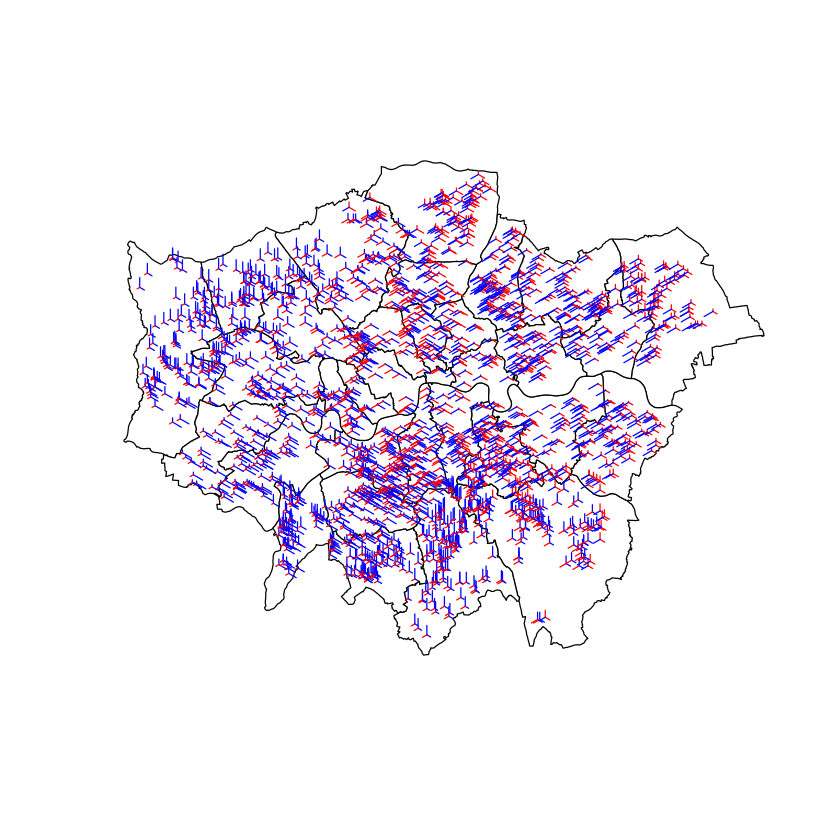

In [10]:
londonhp.loadings <- londonhp.gwpca$loadings[,,1]
plot(londonborough, asp = 1, xaxt = "n", yaxt = "n", xlab = "", ylab = "", bty = "n", col = "white")
glyph.plot(londonhp.loadings, londonhp.gwpca$SDF@coords, add = TRUE)

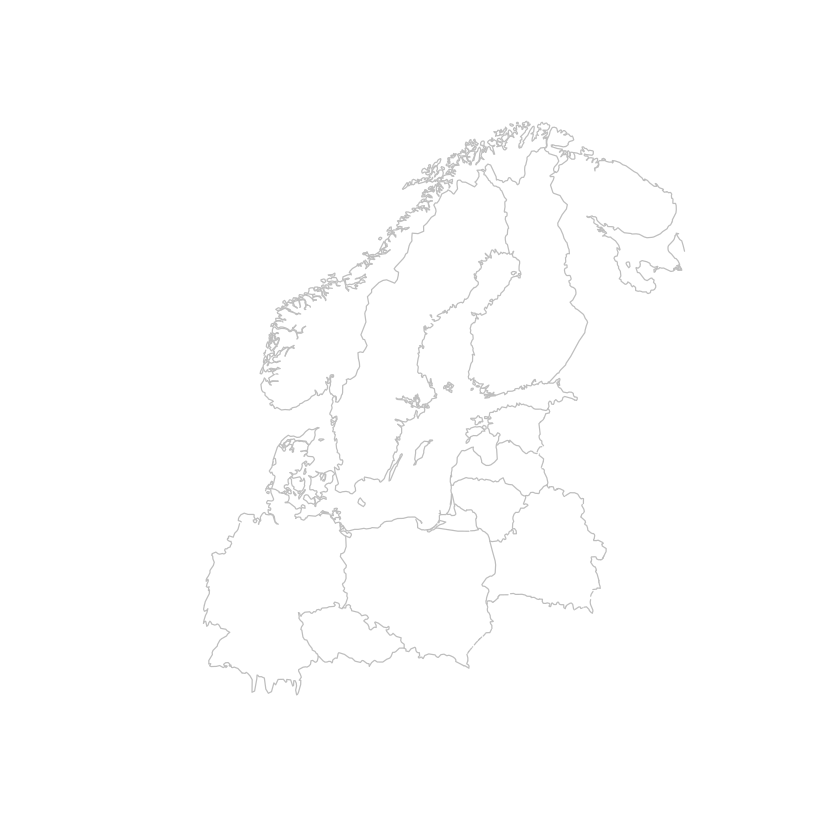

In [33]:
plot(bss.background, asp = 1, type = "l", xaxt = "n", yaxt = "n", 
   xlab = "", ylab = "", bty = "n", col = "grey")
